In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import nivapy3 as nivapy

import matplotlib as mpl
mpl.rcParams["figure.facecolor"]
mpl.rcParams["axes.facecolor"]
mpl.rcParams["savefig.facecolor"]
# plt.style.use('ggplot')

'auto'

In [242]:
site = "Storelva"  # Malselva or Storelva

start_date_dict = {"Malselva": "2018-01-01",
                   "Storelva": "2017-01-01"}  # Tho have data from 2016

# For naming plots and files
site_name_dict = {"Malselva": "Målselva",
                  "Storelva": "Storelva"}

# Read in data

## Read in sensor data

In [243]:
fpath = r'../data/sensor_%s.csv' % site

sensor_df_hourly = pd.read_csv(fpath, index_col=1, parse_dates=True, na_values="NA")
sensor_df_hourly = sensor_df_hourly.drop('station_name', axis=1)
sensor_df_hourly.columns = ["FDOM", "Conductivity", "pH", "T_water", "Turbidity"]
sensor_df_hourly.dropna(how="all", axis=0, inplace=True)
sensor_df_hourly

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2015-02-26 12:42:00+00:00,69.279049,4.046,6.23,1.35,1.54
2015-02-26 13:42:00+00:00,69.591887,4.046,6.23,1.40,1.53
2015-02-26 14:42:00+00:00,69.539249,4.056,6.23,1.39,1.52
2015-02-26 15:42:00+00:00,69.614022,4.041,6.22,1.39,1.50
2015-02-26 16:42:00+00:00,69.757939,4.039,6.22,1.37,1.50
...,...,...,...,...,...
2021-12-31 19:46:00+00:00,71.662322,4.012,6.25,2.39,1.13
2021-12-31 20:46:00+00:00,71.688667,4.028,6.25,2.34,1.12
2021-12-31 21:46:00+00:00,71.798334,3.981,6.25,2.34,1.08


In [244]:
# Round sensor data timestamp to the nearest hour, for joining with Q and grab sample data
sensor_df_hourly.index = sensor_df_hourly.index.round(freq='H')
sensor_df_hourly.sort_index(inplace=True)  # Not sure it was sorted; do in case
sensor_df_hourly.head(2)

,FDOM,Conductivity,pH,T_water,Turbidity
datetime,,,,,
2015-02-26 13:00:00+00:00,69.279049,4.046,6.23,1.35,1.54
2015-02-26 14:00:00+00:00,69.591887,4.046,6.23,1.40,1.53


In [245]:
# Resample to daily

sensor_df = sensor_df_hourly.resample('D').mean()
# Drop time info for joining and plotting
sensor_df.index = sensor_df.index.date
sensor_df

,FDOM,Conductivity,pH,T_water,Turbidity
2015-02-26,69.565192,4.114818,6.225455,1.399091,1.491818
2015-02-27,67.109706,4.129000,6.220417,1.473750,3.201667
2015-02-28,68.694219,4.102958,6.214583,1.511250,2.187500
2015-03-01,65.711247,4.173125,6.113846,1.653333,4.472083
2015-03-02,67.238732,4.020375,NaN,1.735833,3.473750
...,...,...,...,...,...
2021-12-28,70.869126,3.970792,6.179167,1.812917,1.186250
2021-12-29,70.697419,3.809958,6.212083,2.006667,1.153333
2021-12-30,71.491542,3.993417,6.242500,2.283333,1.055833
2021-12-31,71.295408,3.962792,6.241250,2.226250,1.138750


array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

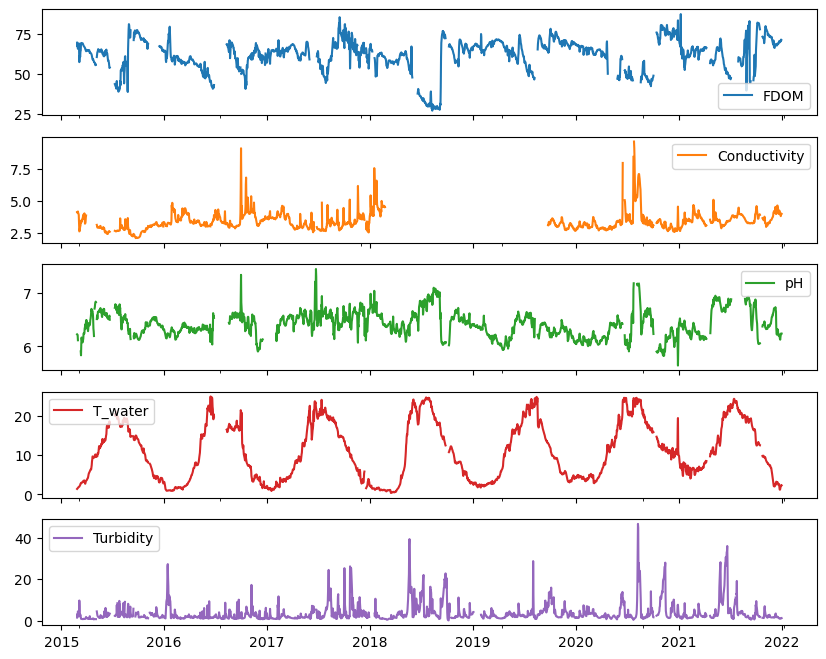

In [246]:
sensor_df.plot(subplots=True, sharex=True, figsize=(10, 8))

## Read in met data

In [247]:
met_fpath = r"../data/Climate_%s_daily.csv" % site
met_df = pd.read_csv(met_fpath, index_col=0, parse_dates=True, dayfirst=False)
met_df = met_df[['par', 'value_mean']]
met_df = met_df.pivot(columns='par')
met_df = met_df.droplevel(level=0, axis=1)
met_df.columns = ['Pptn', 'T_air']
met_df.index = met_df.index.date  # Drop time info
met_df

,Pptn,T_air
2015-01-01,0.0,2.5
2015-01-02,1.3,6.7
2015-01-03,2.1,2.8
2015-01-04,0.4,1.1
2015-01-05,0.0,-0.8
...,...,...
2021-12-27,0.0,-12.3
2021-12-28,1.8,-6.3
2021-12-29,3.3,-4.9
2021-12-30,7.3,-3.8


## Read in discharge data

In [248]:
q_hrly_fpath_dict = {'Malselva': r'../../data/discharge/Q_målselvfossen_alldata_hourly-resolution_downloaded-2022-11.csv',
                     'Storelva': r'../data/Discharge_Storelva_18-4-0_hourly.csv'}

q_hourly_df = pd.read_csv(q_hrly_fpath_dict[site], index_col=0, parse_dates=True)
q_hourly_df.columns = ['Q', 'Korrigert', 'Kontrollert']
q_hourly_df = q_hourly_df['Q']
q_hourly_df.index.name = 'datetime'
q_hourly_df.head()

datetime
2007-11-22 00:00:00+00:00    1.564688
2007-11-22 01:00:00+00:00    1.571511
2007-11-22 02:00:00+00:00    1.582149
2007-11-22 03:00:00+00:00    1.589003
2007-11-22 04:00:00+00:00    1.595874
Name: Q, dtype: float64

In [249]:
q_df = pd.read_csv(r'../data/Discharge_%s.csv' % site, index_col=0, parse_dates=True)

# Drop time info for joining and plotting
q_df.index = q_df.index.date

q_series = q_df['value']
q_series.name = 'Q'
q_series

2015-01-01    5.250791
2015-01-02    5.574467
2015-01-03    5.959798
2015-01-04    5.508568
2015-01-05    5.239527
                ...   
2021-12-26    8.619706
2021-12-27    8.003234
2021-12-28    7.935480
2021-12-29    7.616905
2021-12-30    7.498725
Name: Q, Length: 2556, dtype: float64

**Maeve's Q data is missing the last day of the series. Doesn't matter for now, but in future re-do with raw NVE data**

## Read in grab sample water chem data

In [250]:
chem_df_hrly = pd.read_csv(r'../data/waterchem_%s.csv' % site, index_col=1, parse_dates=True)
chem_df_hrly.drop(chem_df_hrly.columns[0], axis=1, inplace=True)
# Drop rows where there were no samples at all
chem_df_hrly.dropna(axis=0, how="all", inplace=True)

chem_df_hrly.index = chem_df_hrly.index.round(freq='H')
chem_df_hrly.sort_index(inplace=True)  # Not sure it was sorted; do in case

chem_df_hrly.tail()

,pH,Conductivity_mS_m,SPM_mg_L,TOC_mg_L,Turbidity_NTU,PO4_ug_L,TP_ug_L,NO3_ug_L,NH4_ug_L,TN_ug_L,Si_mg_L,Ca_mg_L,DOC_mg_L,PartC_ug_L,PartN_ug_L,TDP_ug_L
datetime,,,,,,,,,,,,,,,,
2021-08-02 12:00:00+00:00,6.67,2.95,3.16,5.5,1.70,2.0,11,120,6.0,370.0,0.814,2.10,5.2,475.0,61.0,NaN
2021-09-06 13:00:00+00:00,6.80,2.55,1.67,4.3,0.87,2.0,7,15,2.0,230.0,0.553,1.96,4.3,708.0,48.4,NaN
2021-10-04 11:00:00+00:00,6.30,3.85,6.67,7.9,4.40,6.0,15,180,NaN,460.0,1.370,1.95,7.6,815.0,64.5,NaN
2021-11-01 08:00:00+00:00,6.53,3.16,5.05,6.2,3.20,6.0,14,140,36.0,470.0,1.390,1.81,6.1,718.0,75.5,NaN
2021-12-13 12:00:00+00:00,6.33,3.07,1.70,5.5,1.30,2.0,6,210,51.0,480.0,1.550,1.80,5.6,240.0,24.3,NaN


In [251]:
# Drop time info for joining and plotting with daily data
chem_df = chem_df_hrly.copy()
chem_df.index = chem_df_hrly.index.date

# Add column for joining with rest of data, simple boolean saying there was a sample this date
chem_df['grab_sample'] = True

chem_df.tail()

,pH,Conductivity_mS_m,SPM_mg_L,TOC_mg_L,Turbidity_NTU,PO4_ug_L,TP_ug_L,NO3_ug_L,NH4_ug_L,TN_ug_L,Si_mg_L,Ca_mg_L,DOC_mg_L,PartC_ug_L,PartN_ug_L,TDP_ug_L,grab_sample
2021-08-02,6.67,2.95,3.16,5.5,1.70,2.0,11,120,6.0,370.0,0.814,2.10,5.2,475.0,61.0,NaN,True
2021-09-06,6.80,2.55,1.67,4.3,0.87,2.0,7,15,2.0,230.0,0.553,1.96,4.3,708.0,48.4,NaN,True
2021-10-04,6.30,3.85,6.67,7.9,4.40,6.0,15,180,NaN,460.0,1.370,1.95,7.6,815.0,64.5,NaN,True
2021-11-01,6.53,3.16,5.05,6.2,3.20,6.0,14,140,36.0,470.0,1.390,1.81,6.1,718.0,75.5,NaN,True
2021-12-13,6.33,3.07,1.70,5.5,1.30,2.0,6,210,51.0,480.0,1.550,1.80,5.6,240.0,24.3,NaN,True


# Join and plot data

## Daily: All but grab samples

In [252]:
df_li = [met_df, q_series, sensor_df, chem_df['grab_sample']]
df = pd.concat(df_li, axis=1, sort=True)

# Fill in 0s for days when there weren't grab samples
df.loc[df['grab_sample'] != 1, 'grab_sample'] = False

index = pd.to_datetime(df.index, yearfirst=True)
df.index = index

# Truncate to start on 01/01/2017
start_date = start_date_dict[site]
df = df.loc[start_date:]

df

,Pptn,T_air,Q,FDOM,Conductivity,pH,T_water,Turbidity,grab_sample
2017-01-01,0.0,6.4,5.536927,57.804370,3.618583,NaN,2.090000,2.544167,False
2017-01-02,0.0,0.5,5.414372,62.152466,3.645625,NaN,1.648333,1.110833,False
2017-01-03,0.0,-2.3,5.180399,62.473917,3.648417,NaN,1.436250,1.168333,False
2017-01-04,0.0,2.4,4.959430,62.392462,3.575917,NaN,1.612917,0.985000,False
2017-01-05,0.0,-3.2,4.556522,65.593442,3.777917,NaN,1.277917,1.129583,False
...,...,...,...,...,...,...,...,...,...
2021-12-28,1.8,-6.3,7.935480,70.869126,3.970792,6.179167,1.812917,1.186250,False
2021-12-29,3.3,-4.9,7.616905,70.697419,3.809958,6.212083,2.006667,1.153333,False
2021-12-30,7.3,-3.8,7.498725,71.491542,3.993417,6.242500,2.283333,1.055833,False
2021-12-31,0.0,2.5,NaN,71.295408,3.962792,6.241250,2.226250,1.138750,False


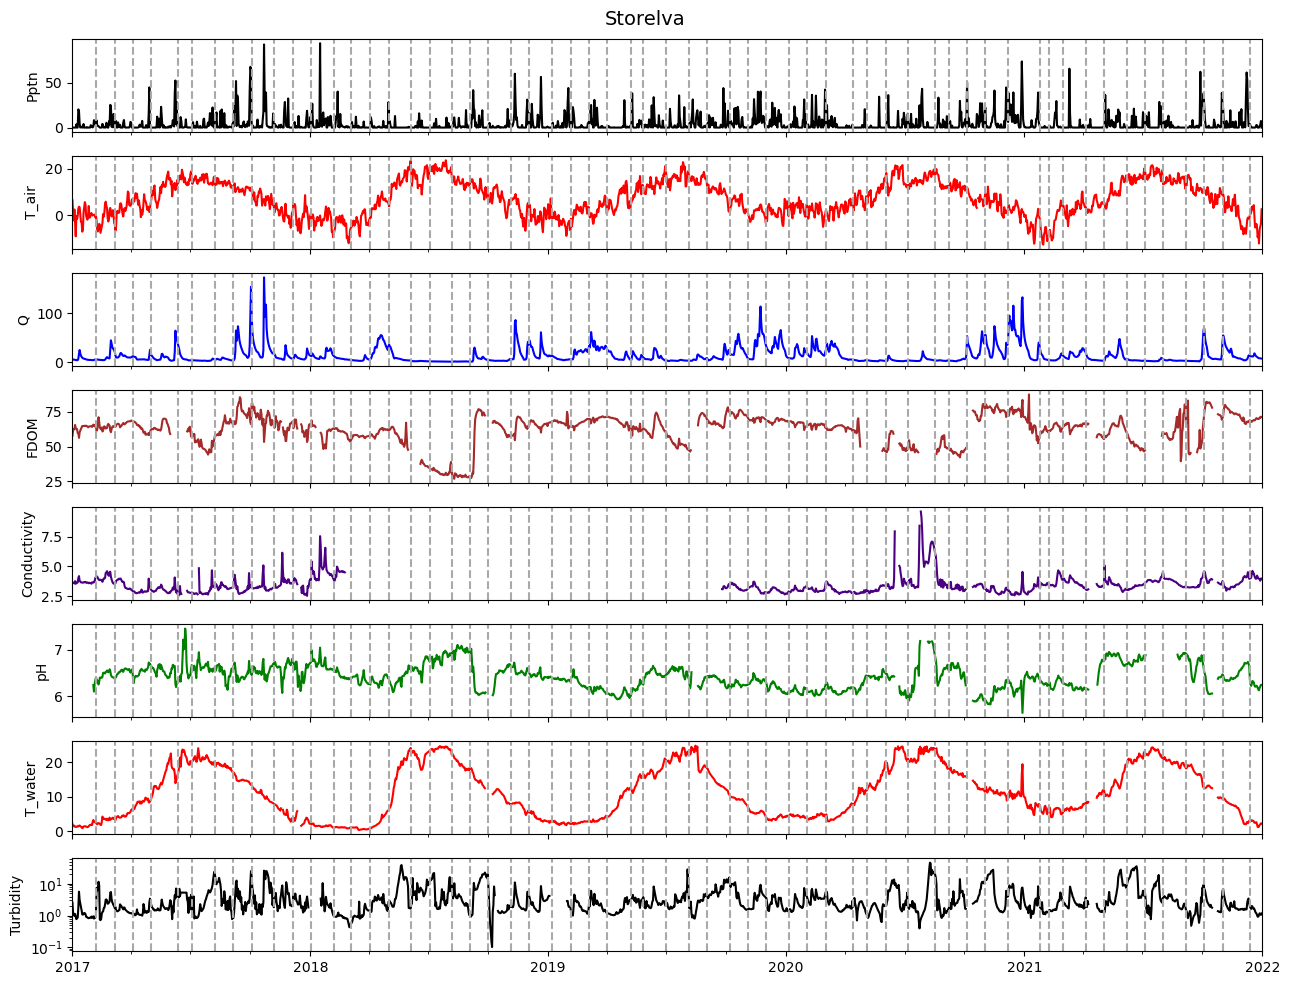

In [253]:
colours = ['black', 'red', 'blue', 'brown', 'indigo', 'green', 'red', 'black']

axs = df.plot(subplots=True, legend=False, figsize=(13, 10), style=colours);
for i, ax in enumerate(axs):
    var = df.columns[i]
    axs[i].set_ylabel(df.columns[i])
    if var=='Turbidity':
        axs[i].set_yscale("log")
    samp_dates = df.loc[df['grab_sample'] == True].index.values
    for date in samp_dates:
        ax.axvline(date, color='darkgray', linestyle='--')

plt.suptitle("%s" % site_name_dict[site], size=14);
plt.tight_layout()

plt.savefig(r'../figures/timeseries_all-data_%s.png' %site)

array([<AxesSubplot:title={'center':'Q'}>,
       <AxesSubplot:title={'center':'Pptn'}>,
       <AxesSubplot:title={'center':'T_air'}>], dtype=object)

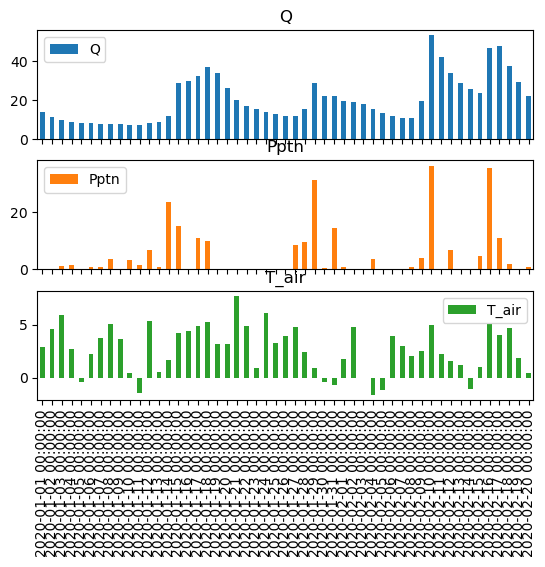

In [254]:
df.loc['2020-01-01':'2020-02-20', ['Q', 'Pptn', 'T_air']].plot(subplots=True, kind='bar')

## Hourly discharge and sensor data

In [255]:
df_li = [sensor_df_hourly, q_hourly_df]
df_hourly = pd.concat(df_li, axis=1, sort=True)

# index = pd.to_datetime(df.index, yearfirst=True)
# df.index = index

# Truncate to start on 01/01/2017
start_date = start_date_dict[site]
df = df.loc[start_date:]

# Quick check it's working; select a period when all should have data
df_hourly.loc['2020-01-01':].head()

,FDOM,Conductivity,pH,T_water,Turbidity,Q
datetime,,,,,,
2020-01-01 00:00:00+00:00,67.848614,2.780,6.06,3.69,1.36,15.65984
2020-01-01 01:00:00+00:00,67.820813,2.780,6.07,3.55,1.41,15.50138
2020-01-01 02:00:00+00:00,67.375453,2.780,6.06,3.49,1.40,15.31825
2020-01-01 03:00:00+00:00,67.236812,2.776,6.07,3.52,1.40,15.11706
2020-01-01 04:00:00+00:00,67.654498,2.745,6.06,3.74,1.39,14.91497


## Add season info to both

In [256]:
# Define 3 seasons per year.
if site == 'Malselva':
    def season(x):
        """Input month number, and return the season it corresponds to
        """
        if x in [5, 6]:
            return 'spring'
        if x in [7, 8]:
            return 'summer'
        else:
            return 'winter'

    def freshet(x):
        """Input month number, return whether freshet or not"""
        if x in [5, 6]:
            return 'Freshet'
        else:
            return 'Not freshet'

elif site == 'Storelva':
    def season(x):
        """Input month number, and return the season it corresponds to
        """
        if x in [3, 4, 5]:
            return 'spring'
        if x in [6, 7, 8]:
            return 'summer'
        if x in [9, 10, 11]:
            return 'autumn'
        else:
            return 'winter'

df_hourly["Season"] = df_hourly.index.month.map(season)
df_hourly.loc[['2020-03-31', '2020-04-01', '2020-06-30', '2020-07-01', '2020-09-30', '2020-10-01']]

,FDOM,Conductivity,pH,T_water,Turbidity,Q,Season
datetime,,,,,,,
2020-03-31 00:00:00+00:00,64.051201,2.927,6.11,5.29,1.59,7.228234,spring
2020-04-01 00:00:00+00:00,64.015274,2.927,6.09,5.55,1.62,6.894495,spring
2020-06-30 00:00:00+00:00,48.780310,4.311,6.00,23.13,1.54,1.942097,summer
2020-07-01 00:00:00+00:00,48.104234,3.528,6.08,22.50,1.67,2.476728,summer
2020-09-30 00:00:00+00:00,46.203338,3.012,6.52,15.68,4.44,7.544398,autumn
2020-10-01 00:00:00+00:00,46.564603,2.877,6.48,15.72,4.37,6.416629,autumn


In [257]:
df["Season"] = df.index.month.map(season)
df.loc[['2020-03-31', '2020-04-01', '2020-06-30', '2020-07-01', '2020-09-30', '2020-10-01']]

/tmp/ipykernel_5077/1472096899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Season"] = df.index.month.map(season)


,Pptn,T_air,Q,FDOM,Conductivity,pH,T_water,Turbidity,grab_sample,Season
2020-03-31,0.0,0.6,7.083655,63.825334,2.890167,6.105833,5.415000,1.705833,False,spring
2020-04-01,0.0,5.9,6.772065,63.510562,2.915125,6.098750,5.517500,1.694583,False,spring
2020-06-30,16.4,13.2,2.145119,49.184239,3.980708,6.025833,22.946250,1.536667,False,summer
2020-07-01,10.6,13.6,2.619124,48.285770,3.780833,6.097917,22.856250,2.058333,False,summer
2020-09-30,5.3,11.4,7.207216,46.626142,3.027333,6.516250,15.775417,4.639167,False,autumn
2020-10-01,4.1,12.7,6.182468,47.576695,2.956875,6.428333,15.949167,2.536250,False,autumn


## Join grab samples for regression

In [258]:
# For DOC
s_li = [sensor_df['FDOM'], chem_df['DOC_mg_L']]
chem_reg_df = pd.concat(s_li, axis=1, join='inner', sort=True)
chem_reg_df.columns = ['FDOM', 'DOC']
index = pd.to_datetime(chem_reg_df.index, yearfirst=True)
chem_reg_df.index = index
chem_reg_df["Season"] = chem_reg_df.index.month.map(season)
if site == 'Malselva':
    chem_reg_df['Freshet'] = chem_reg_df.index.month.map(freshet)
chem_reg_df.dropna(how='all', inplace=True)
chem_reg_df.to_csv(r'../data/fdom_doc_%s.csv' % site)
chem_reg_df.head()

,FDOM,DOC,Season
2017-02-06,64.286106,5.9,winter
2017-03-08,64.197408,5.8,spring
2017-04-04,68.430753,5.6,spring
2017-05-02,62.524505,5.5,spring
2017-06-12,NaN,7.1,summer


array([<AxesSubplot:>, <AxesSubplot:>], dtype=object)

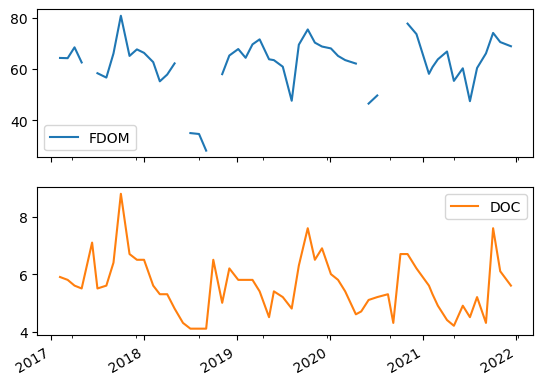

In [259]:
chem_reg_df.plot(subplots=True)

**QC**
* **The 2020 Målselva DOC data are suspiciously high. Decide to drop them for now**
* There's one point in the Målselva grab sample DOC data that I don't believe. Over 2 days there's a huge change in DOC, which isn't seen in FDOM, and there's not much change in Q either. It's a real outlier on the FDOM:DOC plot. So decide to delete that point.

In [260]:
if site == 'Malselva':
    chem_reg_df.loc['2020-07-06', 'DOC'] = np.NaN
    chem_reg_df.dropna(how='any', inplace=True)
    chem_reg_df = chem_reg_df.loc[:'2020-02-01']

**Adding season to this: whether or not it's freshet**

Spring freshet dates according to FLLINK snow coverage data for the full 0-2500m band at 20% threshold:

* 2018: Starts mid-April. Snow gone by end of June, and all the snow that was gonna melt that year gone by around June 8th
* 2019: Start mid-April. Snow gone by end of July, but 
* 2020: Start at start of April. Snow gone by start of August.

For now, we have decided to just classify freshet as May-June

In [261]:
# For SPM
s_li = [sensor_df['Turbidity'], chem_df['SPM_mg_L']]
spm_reg_df = pd.concat(s_li, axis=1, join='inner', sort=True)
spm_reg_df.columns = ['Turbidity', 'SPM']
index = pd.to_datetime(spm_reg_df.index, yearfirst=True)
spm_reg_df.index = index
spm_reg_df.dropna(how='any', inplace=True)

if site == 'Malselva':
    spm_reg_df['Freshet'] = spm_reg_df.index.month.map(freshet)

spm_reg_df.to_csv(r'../data/spm_turbidity_for_regression%s.csv' % site)
spm_reg_df.head()

,Turbidity,SPM
2017-02-06,1.036667,1.74
2017-03-08,1.852917,1.40
2017-04-04,1.119167,1.56
2017-05-02,2.157500,2.48
2017-06-12,6.557917,2.46


# Basic exploratory plots

## Boxplots of sensor and grab sample data


# QC relationships and plots

## Time series

**Ideas for periods to zoom in on:**

**Storelva:**
* Dec2020-Jan2021: example of an acidification episode, i.e. a short-lived drop in pH due to e.g. snowmelt, heavy rainfall and/or seasalt deposition. Sensors detect these acid episodes. The biological response to these episodes depends on the increase in H+ and Al, as well as the timing and duration. Kroglund et al. (2008) showed that at after just 24 hours of exposure smolt mortality was high at pH<5.5, given sufficient Al in the system. https://hess.copernicus.org/articles/12/491/2008/hess-12-491-2008.pdf. **BUT:** when plot hourly data, see that water temp during this "event" increases above 20 degrees and there are data gaps in T and FDOM. Suspicious. Don't believe it.

* August to October 2018: dry summer followed by large rainfall event, with associated sharp peaks/drops. Plot: Q, FDOM, pH, turb.

**Målselva:**
* 2019 freshet, when FDOM rises really high as Q rises a little, then see much smaller increase in subsequent discharge peaks (i.e. first flushing effect, or near-river sources)

<Figure size 640x480 with 0 Axes>

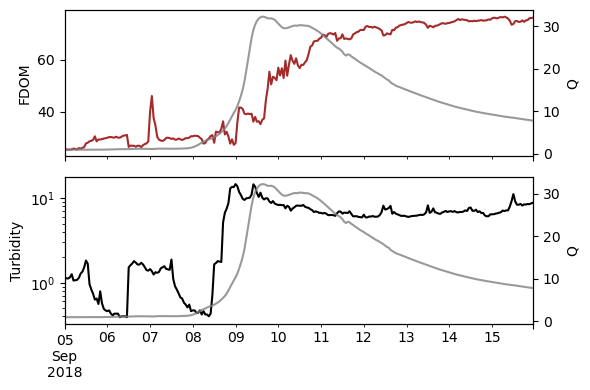

In [262]:
zoom_periods_dict = {'Storelva': ['2018-09-05', '2018-09-15',
                                  ['FDOM', 'Turbidity']],
                     'Malselva': ['2019-04-01', '2019-07-01',
                                  ['FDOM', 'Turbidity']]
                    }

figsize_dict = {'Storelva': (6, 4),
                'Malselva': (8, 4)}

li = zoom_periods_dict[site]

zoom_df = df_hourly.loc[li[0]: li[1], li[2]+['Q']]

# Time series plot
fig = plt.figure()
axs = zoom_df[li[2]].plot(subplots=True, legend=False,
                          style=['brown', 'black'], figsize=figsize_dict[site]);

for i, ax in enumerate(axs):
    ax2 = zoom_df['Q'].plot(secondary_y=True, color='grey', ax=axs[i],
                            mark_right=False, alpha=0.8)
    var = zoom_df.columns[i]

    if var == 'Turbidity':
        axs[i].set_yscale("log")

    axs[i].set_ylabel(zoom_df.columns[i])
    ax2.set_ylabel('Q')
    axs[i].set_xlabel('')

# plt.suptitle("%s" % site_name_dict[site], size=12);

plt.tight_layout()
plt.savefig(r'../figures/timeseries_event-example_%s.png' % site)

In [263]:
# zoom_df.to_csv('../data/%s_%s_to_%s.csv' %(site, li[0], li[1]))

## QC relationships

### Just the chosen events

In [264]:
if site == "Malselva":
    event_df = pd.read_csv('../data/%s_%s_to_%s.csv' % (site, li[0], li[1]), index_col=0, parse_dates=True)
    sns.scatterplot(x="Q", y="FDOM", data=event_df, hue="Event_no", palette="deep", s=10)
    plt.savefig(r'../figures/FDOM-Q_2019freshet_%s_coloured-by-event-no.png' % site)

Text(0.5, 0, 'Q')

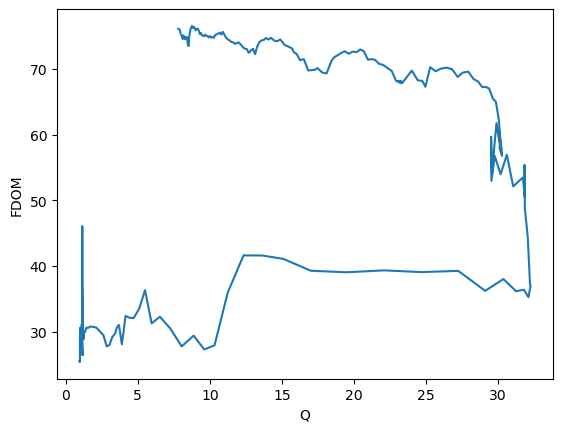

In [265]:
# QC plot (just FDOM)
ax = plt.plot(zoom_df['Q'], zoom_df['FDOM'], marker='', ms=2, linestyle='-')
plt.ylabel('FDOM')
plt.xlabel('Q')
# plt.xscale('log')

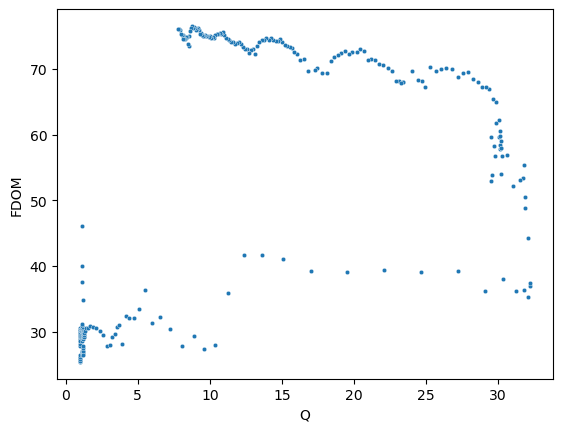

In [266]:
sns.scatterplot(x="Q", y="FDOM", data=zoom_df, s=10)
plt.savefig(r'../figures/FDOM-Q_event_%s.png' % site)

N.B. this R package looks like it could be useful: https://cran.r-project.org/web/packages/hysteresis/vignettes/index.html. Or there's also this python one: https://pypi.org/project/hysteresis/

### Whole period

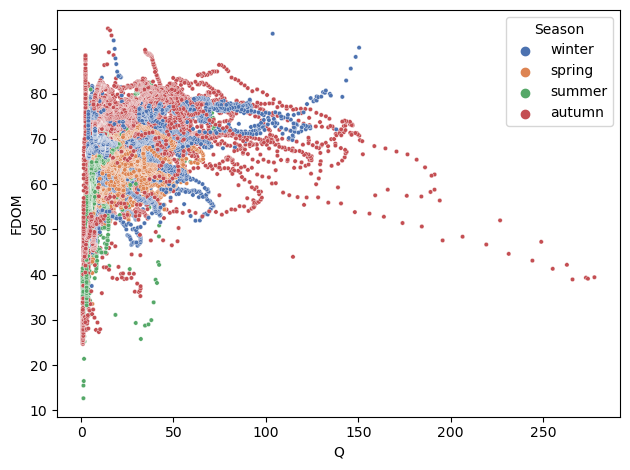

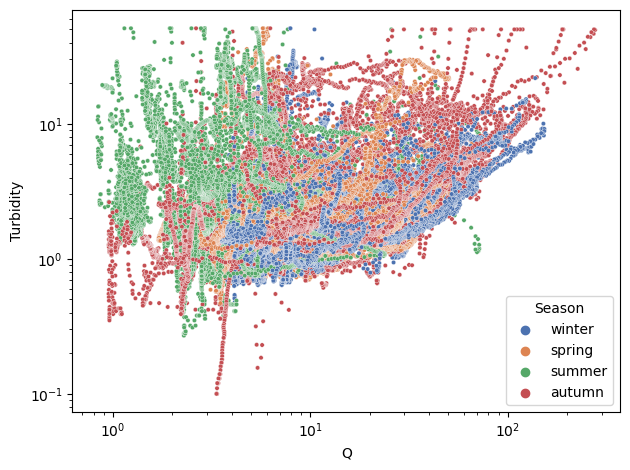

In [267]:
var_li = ["FDOM", "Turbidity"]
if site == 'Malselva':
    hue_order = ['winter', 'spring', 'summer']
else:
    hue_order = ['winter', 'spring', 'summer', 'autumn']

for var in var_li:
    # Hourly data
    fig = plt.figure()
    sns.scatterplot(x="Q", y=var, data=df_hourly, s=10, hue="Season",
                    palette="deep",
                    hue_order=hue_order)

    if site == 'Malselva' and var == 'FDOM':
        plt.ylim(ymax=63)
    if var == 'Turbidity':
        # plt.ylim(ymin=0)
        plt.yscale('log')
        plt.xscale('log')

    plt.tight_layout()
    plt.savefig(r'../figures/FDOM-Q_hourly_AllData_%s-%s.png' % (site, var))

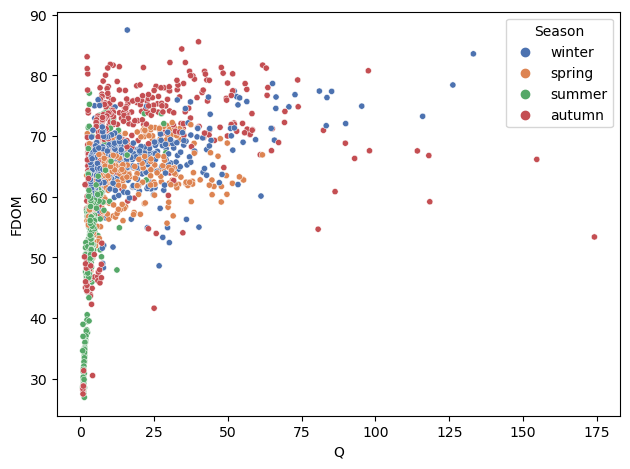

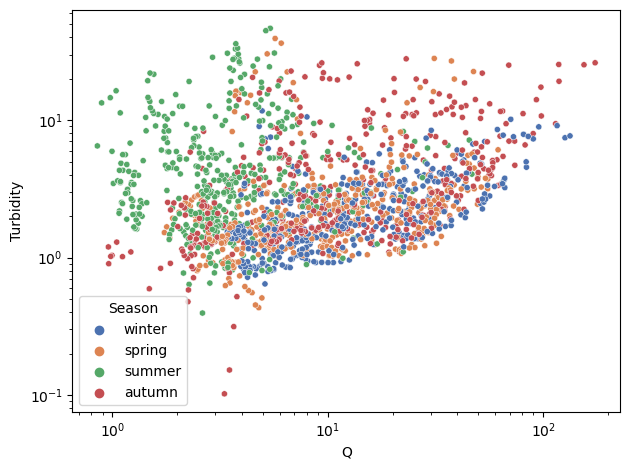

In [268]:
# Daily data

for var in var_li:
    fig = plt.figure()
    sns.scatterplot(x="Q", y=var, data=df, hue="Season", palette="deep",
                    hue_order=hue_order, s=20)
    # if site == "Storelva":

    if var == "Turbidity":
        plt.xscale('log')
        plt.yscale('log')
    plt.tight_layout()
    plt.savefig(r'../figures/FDOM-Q_daily_AllData_%s-%s.png' % (site, var))

In [269]:
# # Different way of doing the same thing
# groups = df_hourly.groupby('Season')

# fig, ax = plt.subplots()
# for name, group in groups:
#     ax.plot(group['Q'], group['FDOM'], marker='o', linestyle='', ms=2, label=name)
# ax.legend()
# # df_hourly.plot(x='Q', y='FDOM', kind='scatter')

# Regressions

## DOC from FDOM

### Basic statsmodels

In [270]:
def ols_regression(df, formula, plot_var):
    """OLS regression using statsmodels. Prints model summary
    and displays diagnostic plots.

    Args
        df:       Dataframe
        formula:  Str. Patsy-style formula
        plot_var: Str. One of the independent variables to analyse
                  using plots

    Returns
        Statsmodels result object.
    """
    import statsmodels.api as sm
    import statsmodels.formula.api as smf

    mod = smf.ols(formula=formula, data=df)
    res = mod.fit()
    print(res.summary())

    # Diagnostic plots
    fig = sm.graphics.plot_regress_exog(res, plot_var)
    fig.tight_layout(pad=1.0)

In [271]:
# res = ols_regression(chem_reg_df, 'DOC ~ FDOM', 'FDOM')

In [272]:
# if site == 'Malselva':
#     # Regression grouping by season
#     groups = chem_reg_df.groupby("Freshet")
#     for season, group_df in groups:
#         print('#############################################################')
#         print(f'# {season}')
#         res = ols_regression(group_df, 'DOC ~ FDOM', 'FDOM')

### With nivapy

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    DOC   R-squared:                       0.530
Model:                            OLS   Adj. R-squared:                  0.521
Method:                 Least Squares   F-statistic:                     57.46
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           6.61e-10
Time:                        15:53:39   Log-Likelihood:                -52.577
No. Observations:                  53   AIC:                             109.2
Df Residuals:                      51   BIC:                             113.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

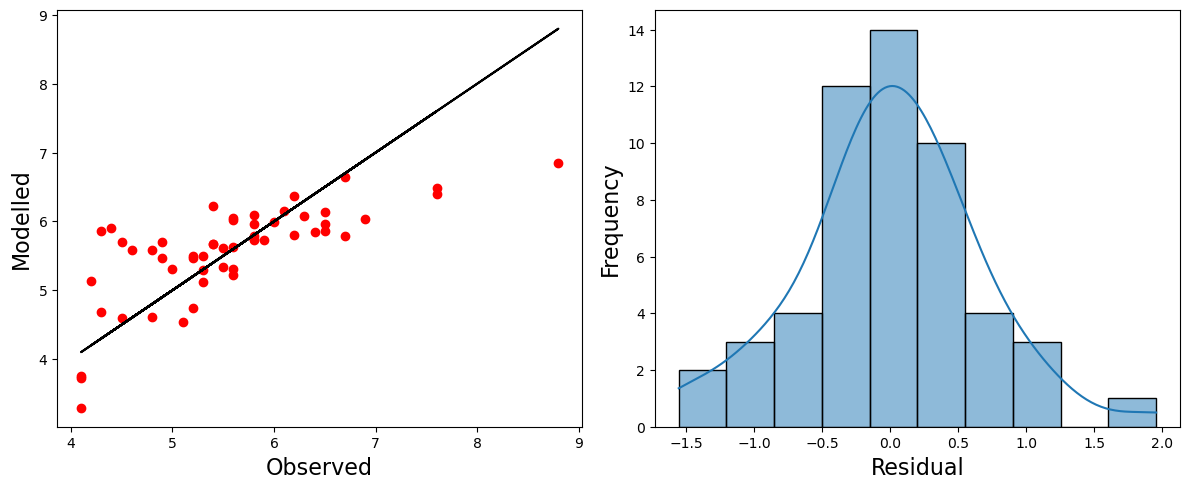

In [274]:
# Best subsets with one combo is the same as 'normal' OLS
doc_res, scalar = nivapy.stats.best_subsets_ols_regression(
    chem_reg_df.dropna(how='any'),
    'DOC',
    ['FDOM'],
    standardise=False,
)

In [275]:
# Can access coefficients
doc_res.params

const    1.397549
FDOM     0.067455
dtype: float64

In [276]:
if site == 'Malselva':
    # Regression grouping by season
    groups = chem_reg_df.groupby("Freshet")
    for season, group_df in groups:
        print('#############################################################')
        print(f'# {season}')
        # Best subsets with one combo is the same as 'normal' OLS
        res, scalar = nivapy.stats.best_subsets_ols_regression(
            group_df, 
            'DOC', 
            ['FDOM'], 
            standardise=False,
        )

For Målselva, get the same regression coefficients using this method as from Excel. Good. But lots more info here and a nice diagnostic plot.

In [277]:
if site == 'Malselva':
    # Regression grouping by season
    groups = chem_reg_df.groupby("Freshet")
    fig, ax = plt.subplots()
    for season, group in groups:
        ax.plot(group['FDOM'], group['DOC'], marker='o', linestyle='', ms=5, label=season)
    ax.legend()
    # df_hourly.plot(x='Q', y='FDOM', kind='scatter')

### Regressions from excel for Målselva

For FDOM for Målselva, grouped into freshet or not

In [278]:
if site == 'Malselva':
    coeffs_df = pd.read_csv(r'../data/Malselva_FDOM-DOC_coeffs.csv', index_col=0, header=1)
    print(coeffs_df)

## SPM from turbidity

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                    SPM   R-squared:                       0.198
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     13.29
Date:                Mon, 07 Nov 2022   Prob (F-statistic):           0.000600
Time:                        15:54:09   Log-Likelihood:                -92.511
No. Observations:                  56   AIC:                             189.0
Df Residuals:                      54   BIC:                             193.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

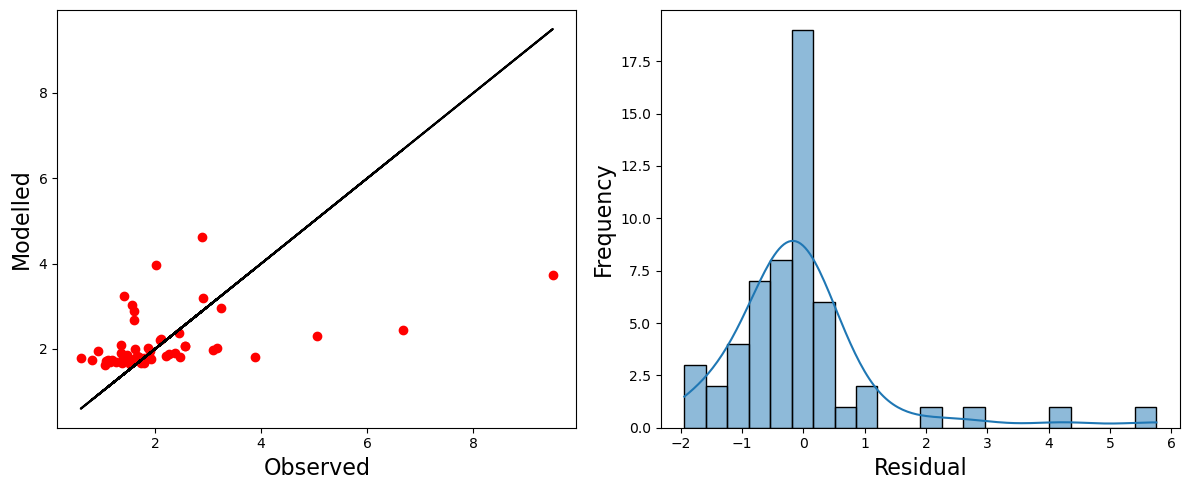

In [279]:
# Best subsets with one combo is the same as 'normal' OLS
spm_res, scalar = nivapy.stats.best_subsets_ols_regression(
    spm_reg_df,
    'SPM',
    ['Turbidity'],
    standardise=False,
)

# Fluxes

3 ways of calculating daily fluxes:
1) Linear interpolation of grab samples at monthly frequency
2) Linear interpolation of grab samples using extra high frequency samples
3) Relationships between sensor data and grab samples, for Målselva split by freshet vs not.

## Caluculate daily fluxes

In [280]:
# flux_daily_df = pd.read_csv(r'../data/%s_daily_fluxes.csv' % site, index_col=0,
#                             parse_dates=True)
# flux_daily_df.head()

# for var in ['DOC']:#, 'SPM']:
#     ax = plt.subplot()
#     df = flux_daily_df.loc[flux_daily_df['variable']==var]
#     for method in ['linear', 'logqc', 'sensor', 'qc']:
#         df['concentration_%s' % method].plot(ax=ax)
#         plt.legend()

In [291]:
fluxes_daily_df = df.loc[:, ['Q', 'FDOM', 'Turbidity']]
fluxes_daily_df = fluxes_daily_df.asfreq('D')

# First interpolate grab samples
chem_df.index = pd.to_datetime(chem_df.index, yearfirst=True)

concat_li = []

for var_long in ['DOC_mg_L', 'SPM_mg_L']:
    var = var_long[:3]

    # Interpolate just monthly samples
    if site == 'Malselva':
        interp_monthly = chem_df.loc[chem_df['sampling'] == 'monthly', '%s' % var_long].asfreq('D').interpolate()
    else:
        interp_monthly = chem_df.loc[:, '%s' % var_long].asfreq('D').interpolate()
    interp_monthly.name = '%s_interp_monthly' % var

    # If Målselva, add extra interpolation and remove dodgy 2020 DOC data
    if site == 'Malselva':
        interp_extra = chem_df.loc[:, '%s' % var_long].asfreq('D').interpolate()
        interp_extra.name = '%s_interp_extra' % var

        if var == 'DOC':
            interp_monthly = interp_monthly.loc[:'2020-01-31']
            interp_extra = interp_extra.loc[:'2020-01-31']

        concat_li.append(interp_extra)

    concat_li.append(interp_monthly)

# Estimate DOC from FDOM
if site == 'Malselva':
    # Split by freshet vs not
    fluxes_daily_df['freshet'] = fluxes_daily_df.index.month.map(freshet)
    freshet_conc = fluxes_daily_df.loc[fluxes_daily_df['freshet'] == 'Freshet', 'FDOM'] * coeffs_df.loc[1, 'm'] + coeffs_df.loc[1, 'c']
    notfreshet_conc = fluxes_daily_df.loc[fluxes_daily_df['freshet'] == 'Not freshet', 'FDOM'] * coeffs_df.loc[0, 'm'] + coeffs_df.loc[0, 'c']
    DOC_FDOM = pd.concat([notfreshet_conc, freshet_conc], axis=0).sort_index()
    DOC_FDOM.name = 'DOC_sensor'
    concat_li.append(DOC_FDOM)
else:
    # No split by season
    fluxes_daily_df['DOC_sensor'] = fluxes_daily_df['FDOM'] * doc_res.params.FDOM + doc_res.params.const

# Estimate SPM from turbidity
fluxes_daily_df['SPM_sensor'] = fluxes_daily_df['Turbidity'] * spm_res.params.Turbidity + spm_res.params.const

concat_li.append(fluxes_daily_df)

# Add to master fluxes df
fluxes_daily_df = pd.concat(concat_li, axis=1)

# Calculate fluxes in tonnes/day
for col in ['DOC_interp_monthly', 'DOC_interp_extra', 'DOC_sensor',
            'SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']:
    if col in fluxes_daily_df.columns:
        fluxes_daily_df['flux_%s' % col] = fluxes_daily_df[col] * fluxes_daily_df['Q'] * 86400 * 10**-6

# Fill in any short NaN periods
print(fluxes_daily_df[['FDOM', 'Turbidity']].isna().sum())
fluxes_daily_df = fluxes_daily_df.interpolate(method='linear', axis=0, limit=10)
print(fluxes_daily_df[['FDOM', 'Turbidity']].isna().sum())

fluxes_daily_df.loc['2019-05-01': '2019-05-08']

FDOM         211
Turbidity     79
dtype: int64
FDOM         81
Turbidity    26
dtype: int64


,DOC_interp_monthly,SPM_interp_monthly,Q,FDOM,Turbidity,DOC_sensor,SPM_sensor,flux_DOC_interp_monthly,flux_DOC_sensor,flux_SPM_interp_monthly,flux_SPM_sensor
2019-05-01,4.670270,1.768108,21.731830,67.583400,3.155000,5.956417,1.944170,8.769040,11.183947,3.319853,3.650433
2019-05-02,4.645946,1.788378,16.025890,67.597281,3.832500,5.957353,2.029678,6.432948,8.248771,2.476255,2.810366
2019-05-03,4.621622,1.808649,13.633680,66.178641,2.297917,5.861658,1.835998,5.444039,6.904740,2.130498,2.162713
2019-05-04,4.597297,1.828919,10.666180,64.189154,2.355833,5.727456,1.843307,4.236676,5.278183,1.685455,1.698715
2019-05-05,4.572973,1.849189,8.819996,61.502031,2.917083,5.546195,1.914143,3.484823,4.226465,1.409170,1.458668
2019-05-06,4.548649,1.869459,6.182560,63.322375,3.055417,5.668987,1.931602,2.429766,3.028221,0.998615,1.031810
2019-05-07,4.524324,1.889730,5.241099,65.115844,2.985417,5.789967,1.922767,2.048754,2.621876,0.855728,0.870688
2019-05-08,4.500000,1.910000,4.104204,63.761898,3.172083,5.698636,1.946326,1.595715,2.020755,0.677292,0.690174


## Daily flux plots

In [293]:
# DOC, 2019
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['DOC_interp_monthly', 'DOC_interp_extra', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_freshet-2019.png' % site)

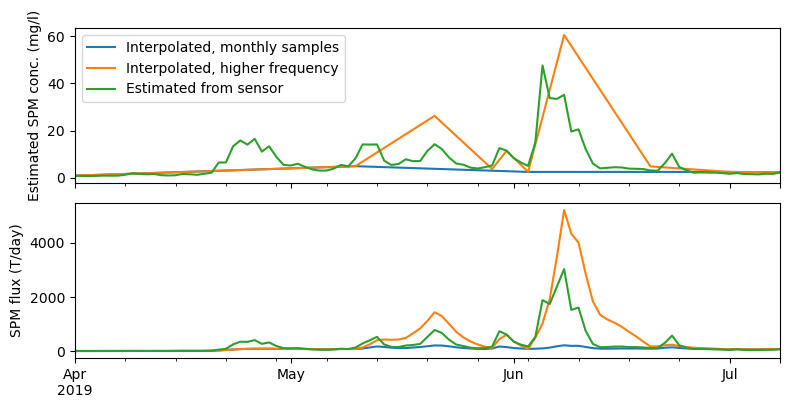

In [174]:
# SPM
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['SPM_interp_monthly', 'SPM_interp_extra', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2019-04-01': '2019-07-08',
                        ['flux_SPM_interp_monthly', 'flux_SPM_interp_extra', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_freshet-2019.png' % site)

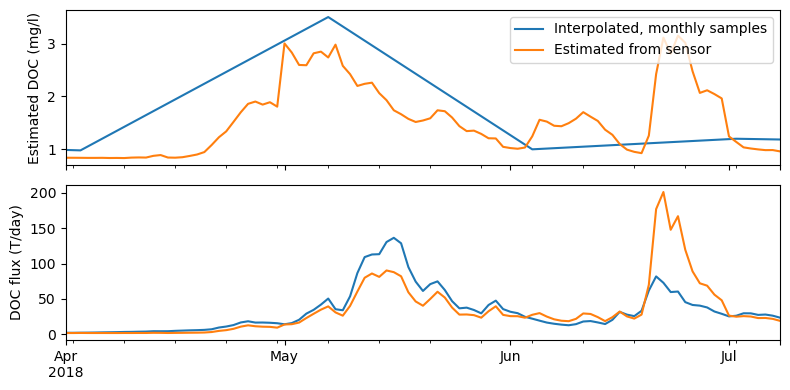

In [236]:
# DOC, 2018
if site == 'Malselva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-04-01': '2018-07-08',
                        ['DOC_interp_monthly', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2018-04-01': '2018-07-08',
                        ['flux_DOC_interp_monthly', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_freshet-2018.png' % site)

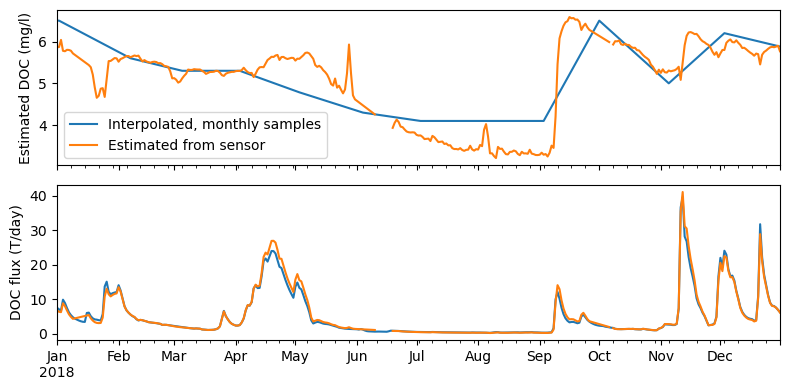

In [296]:
# DOC, 2018
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['DOC_interp_monthly', 'DOC_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated DOC (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Estimated from sensor'])

    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['flux_DOC_interp_monthly', 'flux_DOC_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('DOC flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/DOC_daily_fluxes_%s_2018.png' % site)

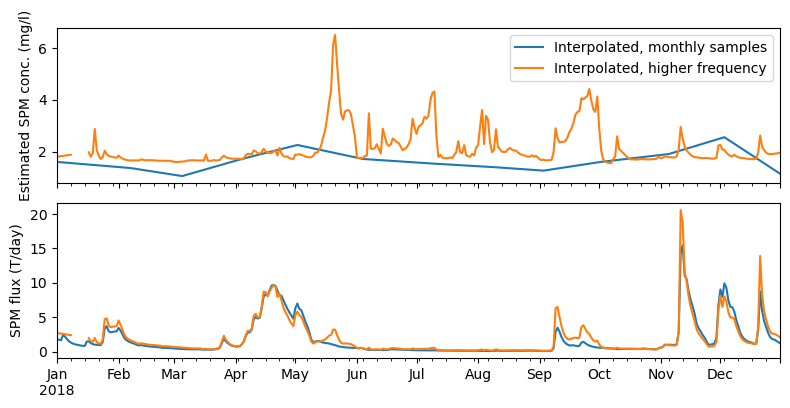

In [297]:
# SPM
if site == 'Storelva':
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(8, 4))
    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['SPM_interp_monthly', 'SPM_sensor']].plot(ax=axs[0])
    axs[0].set_ylabel('Estimated SPM conc. (mg/l)')

    axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
                          'Estimated from sensor'])

    fluxes_daily_df.loc['2018-01-01': '2018-12-31',
                        ['flux_SPM_interp_monthly', 'flux_SPM_sensor']].plot(ax=axs[1], legend=False)
    axs[1].set_ylabel('SPM flux (T/day)')

    plt.tight_layout()
    plt.savefig(r'../figures/SPM_daily_fluxes_%s_2018.png' % site)

## Monthly flux plots

In [237]:
# fluxes_monthly_df['date'] = fluxes_monthly_df.index
# new_index = fluxes_monthly_df['date'].apply(lambda x: x.strftime('%Y-%m'))
# # new_index = pd.to_datetime(new_index)
# fluxes_monthly_df.set_index(new_index, inplace=True)

# # index = pd.to_datetime(df.index, yearfirst=True)
# # df.index = index

# fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 5))

# for i, var in enumerate(['DOC', 'SPM']):
#     if var == 'DOC':
#         legend=True
#     else:
#         legend=False
#     fluxes_monthly_df[['flux_%s_interp_monthly' % var,
#                        'flux_%s_interp_extra' % var,
#                        'flux_%s_sensor' % var]].plot(kind='bar',
#                                                      figsize=(10, 5),
#                                                      ax=axs[i], legend=legend)
#     axs[i].set_ylabel('%s load (T/month)' % var)
#     axs[i].set_xlabel('')

# axs[0].legend(labels=['Interpolated, monthly samples', 'Interpolated, higher frequency',
#                       'Estimated from sensor'])
#     # #set ticks every week
#     # axs[i].xaxis.set_major_locator(mdates.MonthLocator())
#     # #set major ticks format
#     # axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))

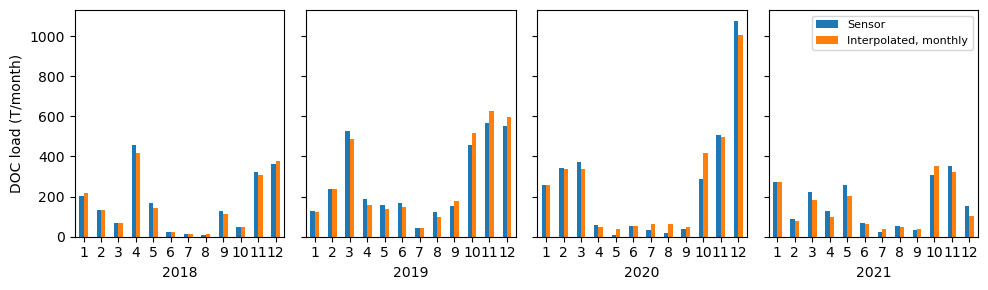

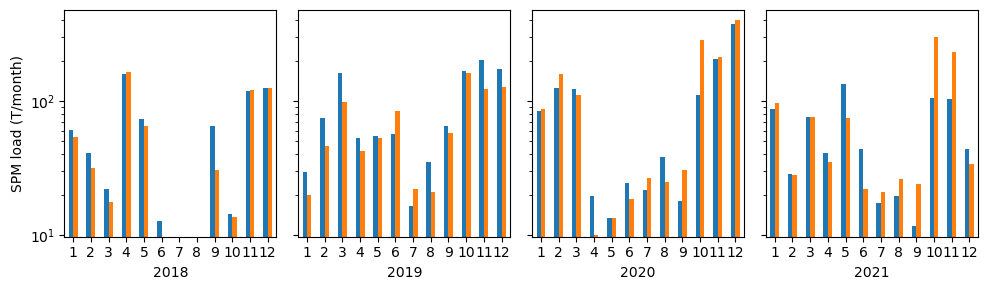

In [301]:
if site == 'Malselva':
    col_li = ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra',
              'flux_DOC_sensor', 'flux_SPM_interp_monthly',
              'flux_SPM_interp_extra', 'flux_SPM_sensor']
else:
    col_li = ['flux_DOC_interp_monthly', 'flux_DOC_sensor',
              'flux_SPM_interp_monthly', 'flux_SPM_sensor']

fluxes_monthly_df = fluxes_daily_df.loc[:, col_li].resample('M').sum()

index = pd.to_datetime(fluxes_monthly_df.index)
fluxes_monthly_df.index = index

yr_li_dict = {'Malselva': {'DOC': [2018, 2019],
                           'SPM': [2018, 2019, 2020, 2021]},
              'Storelva': {'DOC': [2018, 2019, 2020, 2021],
                           'SPM': [2018, 2019, 2020, 2021]}}

for var in ['DOC', 'SPM']:
    yr_li = yr_li_dict[site][var]
    fig, axs = plt.subplots(1, len(yr_li), sharey=True, figsize=(10, 3))
    for i, yr in enumerate(yr_li):
        if yr == 2019 and site == 'Malselva':
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var,
                                           'flux_%s_interp_extra' % var,]]
        else:
            yr_df = fluxes_monthly_df.loc[fluxes_monthly_df.index.year == yr,
                                          ['flux_%s_sensor' % var,
                                           'flux_%s_interp_monthly' % var]]
        yr_df.index = yr_df.index.month
        yr_df.plot(kind='bar', ax=axs[i], legend=False)
        axs[i].set_ylabel('%s load (T/month)' % var)
        axs[i].set_xlabel(yr)
        axs[i].tick_params(axis='x', labelrotation=0)

    if var == 'DOC':
        if site == 'Malselva':
            axs[-1].legend(labels=['Sensor', 'Interpolated, monthly',
                           'Interpolated, extra'])
        else:
            axs[-1].legend(labels=['Sensor', 'Interpolated, monthly'],
                          prop={'size': 8})

    if var == 'SPM':
        axs[i].set_yscale("log")
    plt.tight_layout()
    plt.savefig(r'../figures/monthly_fluxes_%s_%s.png' % (site, var))

## Annual fluxes

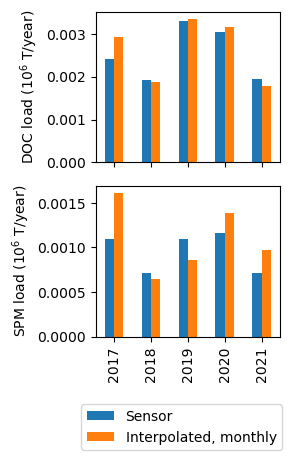

In [304]:
fluxes_yr_df = fluxes_daily_df.loc[:, col_li].resample('Y').sum()
# Convert to megatonnes (10^6 tonnes/year)
fluxes_yr_df = fluxes_yr_df/10**6

fluxes_yr_df.index = fluxes_yr_df.index.year

# Remove estimates based on grab samples for 2020 and 2021 (almost no data)
if site == 'Malselva':
    fluxes_yr_df.loc[[2020, 2021], ['flux_DOC_interp_monthly', 'flux_DOC_interp_extra']] = np.NaN
    fluxes_yr_df.loc[[2021], ['flux_DOC_sensor']] = np.NaN
    # Also remove 'interpolated_extra' fluxes for 2018 and 2020 for Målselva
    fluxes_yr_df.loc[[2018, 2021], ['flux_DOC_interp_extra', 'flux_SPM_interp_extra']] = np.NaN
    # Turbidity was only measured from mid-2018, so drop
    fluxes_yr_df.loc[2018, 'flux_SPM_sensor'] = np.NaN

if site == 'Storelva':
    fluxes_yr_df.loc[2022, :] = np.NaN

fluxes_yr_df.dropna(how='all', inplace=True)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(3, 4))

for i, var in enumerate(['DOC', 'SPM']):
    if site == 'Malselva':
        var_li = ['flux_%s_sensor' % var,
                  'flux_%s_interp_monthly' % var,
                  'flux_%s_interp_extra' % var]
    else:
        var_li = ['flux_%s_sensor' % var,
                  'flux_%s_interp_monthly' % var]

    fluxes_yr_df[var_li].plot(kind='bar',
                              ax=axs[i], legend=False)

    axs[i].set_ylabel('%s load (10$^6$ T/year)' % var)
    axs[i].set_xlabel('')

plt.tight_layout()

axs[1].legend(labels=['Sensor', 'Interpolated, monthly',
                      'Interpolated, extra'],
             loc='right', bbox_to_anchor=(1.05, -0.6),
             fancybox=True)

# To do

* Boxplots grouped by season, plus for grab samples to compare
* Split into different periods: baseflow, snow melt, summer/autumn flow events